# Case 3: Benchmark and Method validation
Comparison between implicit and explicit H-bond methods

In [28]:
import os

from prolif.io.protein_helper import ProteinHelper

protein_helper = ProteinHelper(
    templates=[
        {
            "MSE": {"SMILES": "C[Se]CC[CH](N)C=O"},
        }
    ]
)

In [29]:
test_case_dir = "./test_data/5da9__1__1.A_1.B__1.E_1.F"

### Explicit

In [30]:
from prolif.molecule import Molecule
from rdkit import Chem

mol = Chem.MolFromPDBFile(
    f"{test_case_dir}/receptor_protonated.pdb",
    sanitize=False,
    removeHs=False,
    proximityBonding=True,
)

protein_mol = Molecule.from_rdkit(mol)
protein_mol = protein_helper.standardize_protein(protein_mol)

In [31]:
protein_mol.residues.__len__()

834

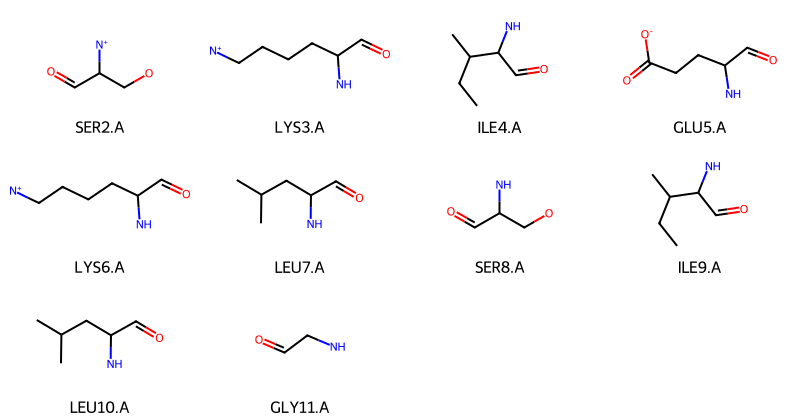

In [32]:
import prolif as plf

plf.display_residues(protein_mol, slice(0, 10), sanitize=False)

In [33]:
from prolif import sdf_supplier

ligands = []
for ligand_sdf in os.listdir(test_case_dir):  # noqa: PTH208
    if ligand_sdf.endswith("_protonated.sdf"):
        ligands.extend(sdf_supplier(f"{test_case_dir}/{ligand_sdf}"))

In [34]:
ligands

[<prolif.molecule.Molecule with 1 residues and 47 atoms at 0x7f7145020a40>,
 <prolif.molecule.Molecule with 1 residues and 1 atoms at 0x7f7145020810>]

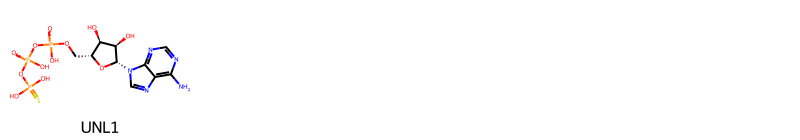

In [35]:
plf.display_residues(ligands[0])

In [36]:
ligand = ligands[0]

In [37]:
fp = plf.Fingerprint(["HBDonor", "HBAcceptor"], count=True)
fp.run_from_iterable([ligand], protein_mol, progress=False)
df = fp.to_dataframe().T

In [38]:
df

Frame                        0
ligand protein  interaction   
UNL1   ARG13.A  HBAcceptor   1
       ASN36.A  HBAcceptor   1
       GLY37.A  HBAcceptor   1
       GLY39.A  HBAcceptor   1
       LYS40.A  HBAcceptor   1
       THR41.A  HBAcceptor   1
       THR42.A  HBAcceptor   1
       ALA64.A  HBDonor      1
       ASP68.A  HBAcceptor   1
       GLN159.A HBAcceptor   1
       ARG431.A HBAcceptor   1
       GLY344.B HBAcceptor   1
       GLN345.B HBAcceptor   1

In [39]:
view = fp.plot_lignetwork(ligand, kind="frame", frame=0, display_all=False)
view

In [40]:
# Somtimes not working, need to check
view = fp.plot_3d(ligand, protein_mol, frame=0, display_all=True)
view

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

### Implicit

In [41]:
from prolif.molecule import Molecule

protein_mol_i = protein_helper.standardize_protein(
    Molecule.from_rdkit(Chem.RemoveAllHs(protein_mol))
)

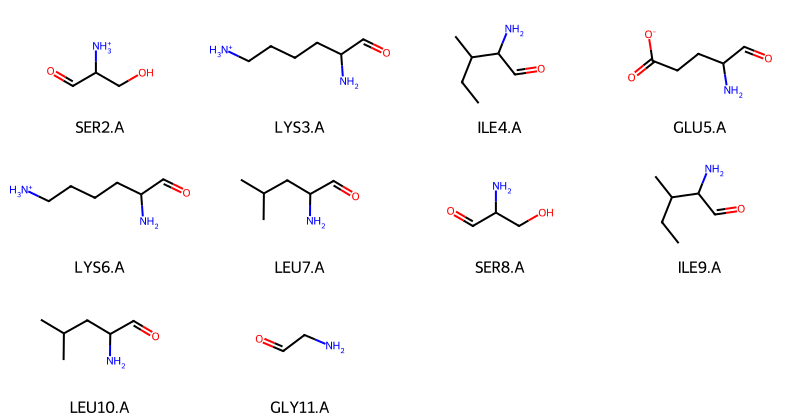

In [42]:
plf.display_residues(protein_mol_i, slice(0, 10), sanitize=False)

In [43]:
ligand_i = Molecule.from_rdkit(Chem.RemoveAllHs(ligand))

In [44]:
fp_i = plf.Fingerprint(
    ["ImplicitHBDonor", "ImplicitHBAcceptor"],
    count=True,
)
fp_i.run_from_iterable([ligand_i], protein_mol_i, progress=False)
df_i = fp_i.to_dataframe().T

In [45]:
df_i

Frame                               0
ligand protein  interaction          
UNL1   ARG13.A  ImplicitHBAcceptor  1
       ASN36.A  ImplicitHBAcceptor  1
       GLY37.A  ImplicitHBDonor     1
                ImplicitHBAcceptor  1
       SER38.A  ImplicitHBDonor     1
                ImplicitHBAcceptor  2
       GLY39.A  ImplicitHBAcceptor  1
       LYS40.A  ImplicitHBDonor     1
                ImplicitHBAcceptor  2
       THR41.A  ImplicitHBAcceptor  3
       THR42.A  ImplicitHBAcceptor  2
       ALA64.A  ImplicitHBDonor     1
       ASP68.A  ImplicitHBAcceptor  1
       SER342.B ImplicitHBDonor     1
                ImplicitHBAcceptor  1
       GLY344.B ImplicitHBAcceptor  1
       GLN345.B ImplicitHBAcceptor  1

In [46]:
view = fp_i.plot_lignetwork(ligand_i, kind="frame", display_all=False)
view

In [47]:
from prolif.plotting.complex3d import Complex3D

# create Complex3D objects (default)
comp3D = Complex3D.from_fingerprint(fp, ligand, protein_mol, frame=0)
# (modified)
other_comp3D = Complex3D.from_fingerprint(fp_i, ligand_i, protein_mol_i, frame=0)

# compare the two Complex3D objects
view = comp3D.compare(other_comp3D, display_all=True)
view

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [48]:
from validation.utils.metrics import (
    confusion_matrix,
    get_interactions,
    plot_confusion_matrix,
    tanimoto_coefficient_by_confusion_matrix,
)

In [49]:
explicit_set = get_interactions(df)
implicit_set = get_interactions(df_i)

matrix = confusion_matrix(explicit_set, implicit_set)
tm_coef = tanimoto_coefficient_by_confusion_matrix(matrix)

Tanimoto coefficient: 0.5789473684210527


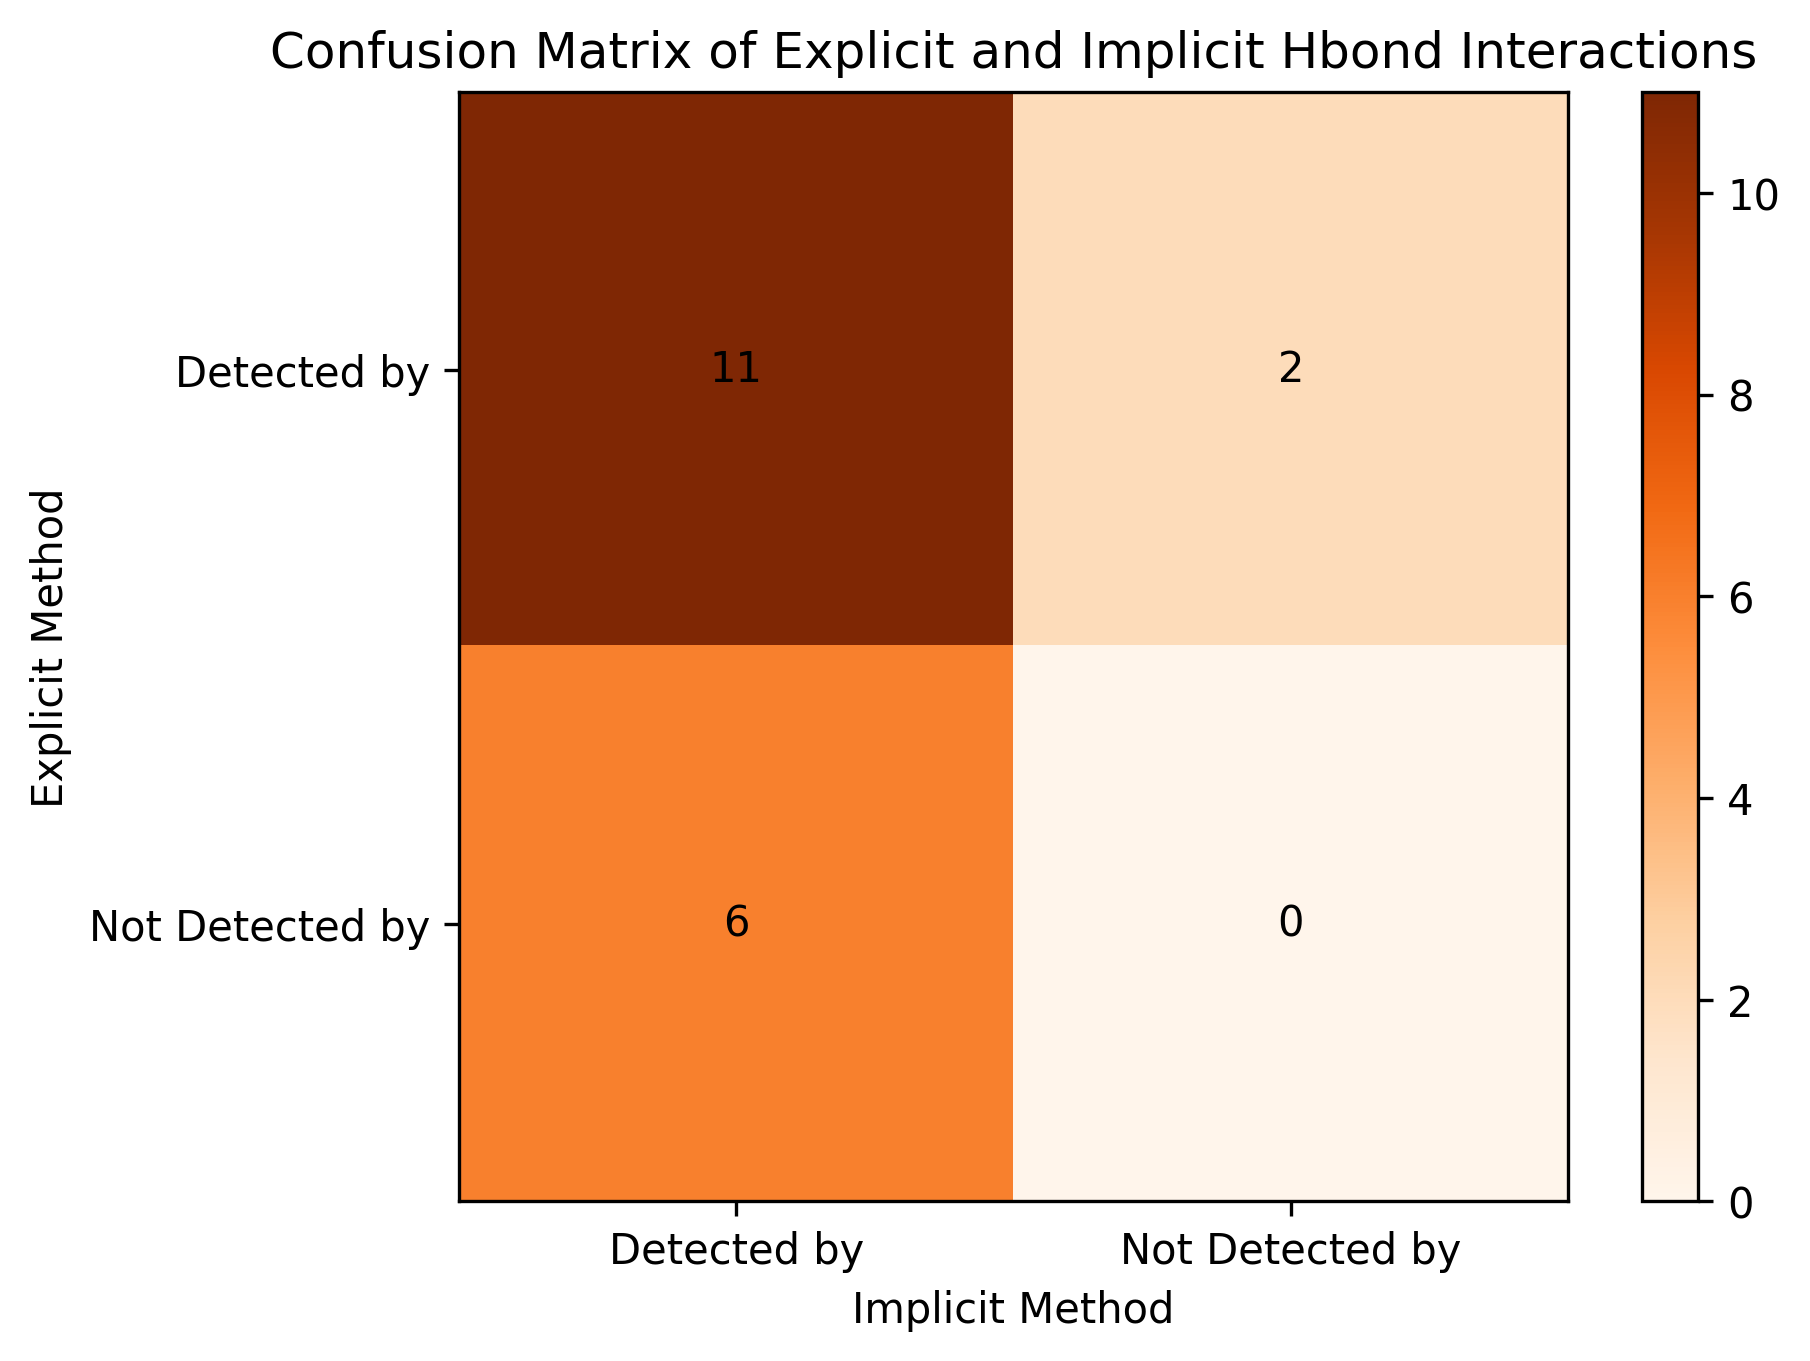

In [50]:
print("Tanimoto coefficient:", tm_coef)  # noqa: T201
fig, ax = plot_confusion_matrix(matrix)
fig.show()